In [40]:
!wget https://s3.amazonaws.com/hr-testcases/859/assets/training.json

--2020-02-07 09:21:19--  https://s3.amazonaws.com/hr-testcases/859/assets/training.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.104.85
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.104.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2321936 (2.2M) [application/octet-stream]
Saving to: ‘training.json’

training.json       100%[===================>]   2.21M  1.99MB/s    in 1.1s    

2020-02-07 09:21:21 (1.99 MB/s) - ‘training.json’ saved [2321936/2321936]



In [0]:
import json    

data = []
with open('training.json') as f:
    for line in f:
        data.append(json.loads(line))

In [42]:
data[1:2]

[{'category': 'cell-phones',
  'city': 'newyork',
  'heading': 'New batteries C-S2 for Blackberry 7100/7130/8700/Curve/Pearl',
  'section': 'for-sale'}]

In [0]:
my_data = data[1:]

In [0]:
category = []
city = []
heading = []
section = []

for i in my_data:
  
  category.append(i["category"])
  city.append(i["city"])
  heading.append(i["heading"])
  section.append(i["section"])

In [0]:
import pandas as pd
data_new = pd.DataFrame(
    {'city': city,
     'section': section,
     'heading': heading,
     'category':category
    })

In [46]:
data_new.head()

,city,section,heading,category
0,newyork,for-sale,New batteries C-S2 for Blackberry 7100/7130/8700/Curve/Pearl,cell-phones
1,newyork,for-sale,******* Brand New Original SAMSUNG GALAXY NOTE 2 BATTERY ******,cell-phones
2,newyork,for-sale,SAMSUNG GALAXY SIII T-999 MARBLE WHITE T-MOBILE SMARTPHONE BRAND NEW,cell-phones
3,newyork,for-sale,Ipad mini 64gb 4g any sim unlock,cell-phones
4,newyork,for-sale,htc evo 4g lte for trade,cell-phones


In [47]:
data_new["category"].value_counts()

shared                2273
therapeutic           2203
cell-phones           1741
temporary             1518
appliances            1443
household-services    1381
photography           1379
wanted-housing        1378
childcare             1255
video-games           1249
automotive            1136
real-estate           1048
general               1020
artists               439 
housing               397 
activities            357 
Name: category, dtype: int64

[Text(0, 0, 'cell-phones'),
 Text(0, 0, 'appliances'),
 Text(0, 0, 'photography'),
 Text(0, 0, 'video-games'),
 Text(0, 0, 'housing'),
 Text(0, 0, 'shared'),
 Text(0, 0, 'temporary'),
 Text(0, 0, 'wanted-housing'),
 Text(0, 0, 'activities'),
 Text(0, 0, 'artists'),
 Text(0, 0, 'childcare'),
 Text(0, 0, 'general'),
 Text(0, 0, 'automotive'),
 Text(0, 0, 'household-services'),
 Text(0, 0, 'real-estate'),
 Text(0, 0, 'therapeutic')]

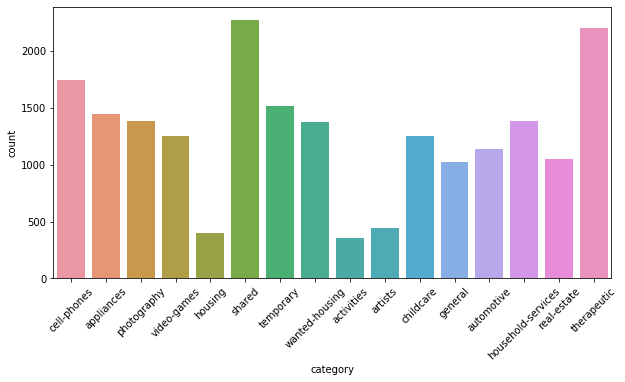

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data_new["category"])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [49]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20217 entries, 0 to 20216
Data columns (total 4 columns):
city        20217 non-null object
section     20217 non-null object
heading     20217 non-null object
category    20217 non-null object
dtypes: object(4)
memory usage: 631.9+ KB


In [0]:
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical

In [0]:
targets = data_new["category"].values

In [0]:
encoder = LabelBinarizer()
encoder.fit(targets)
y_train = encoder.transform(targets)

In [0]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

In [54]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-02-07 09:24:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-07 09:24:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-07 09:24:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall("glove")
zip_ref.close()

In [56]:
import numpy as np
# some configuration
MAX_SEQUENCE_LENGTH = 50
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5



# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open("glove/glove.6B.300d.txt") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [0]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data_new["heading"])
sequences = tokenizer.texts_to_sequences(data_new["heading"])

In [58]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))


# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Found 12743 unique tokens.
Shape of data tensor: (20217, 50)


In [59]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [60]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)



print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
# x = LSTM(15, return_sequences=True)(x)
x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(16, activation="softmax")(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

Building model...


In [61]:
print('Training model...')
r = model.fit(
  data,
  y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 16173 samples, validate on 4044 samples
Epoch 1/5
16173/16173 [==============================] - 21s 1ms/step - loss: 0.1257 - acc: 0.9597 - val_loss: 0.0938 - val_acc: 0.9688
Epoch 2/5
16173/16173 [==============================] - 19s 1ms/step - loss: 0.0886 - acc: 0.9705 - val_loss: 0.0944 - val_acc: 0.9692
Epoch 3/5
16173/16173 [==============================] - 20s 1ms/step - loss: 0.0785 - acc: 0.9741 - val_loss: 0.0994 - val_acc: 0.9674
Epoch 4/5
16173/16173 [==============================] - 19s 1ms/step - loss: 0.0723 - acc: 0.9764 - val_loss: 0.0949 - val_acc: 0.9682
Epoch 5/5
16173/16173 [==============================] - 18s 1ms/step - loss: 0.0673 - acc: 0.9783 - val_loss: 0.1048 - val_acc: 0.9667


In [62]:
!wget https://s3.amazonaws.com/hr-testcases/859/sample-test.in.json

--2020-02-07 09:33:53--  https://s3.amazonaws.com/hr-testcases/859/sample-test.in.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.126
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385338 (1.3M) [application/octet-stream]
Saving to: ‘sample-test.in.json’

sample-test.in.json 100%[===================>]   1.32M  1.20MB/s    in 1.1s    

2020-02-07 09:33:55 (1.20 MB/s) - ‘sample-test.in.json’ saved [1385338/1385338]



In [0]:
data_input = []
with open('sample-test.in.json') as f:
    for line in f:
        data_input.append(json.loads(line))

In [0]:
test_data = data_input[1:]

In [0]:
city = []
heading = []
section = []

for i in test_data:
  
  city.append(i["city"])
  heading.append(i["heading"])
  section.append(i["section"])

In [0]:

test = pd.DataFrame(
    {'city': city,
     'section': section,
     'heading': heading,
     })

In [67]:
test.head()

,city,section,heading
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!
1,paris.en,housing,looking for room to rent.
2,newyork,for-sale,two DS game
3,seattle,housing,map
4,singapore,services,Good Looking Asian Sensation N aughty Girl ---- Independent


In [68]:
test.shape

(15370, 3)

In [0]:
test_sequences = tokenizer.texts_to_sequences(test["heading"])

In [0]:
test_pad = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [0]:
text_labels = encoder.classes_

In [72]:
text_labels

array(['activities', 'appliances', 'artists', 'automotive', 'cell-phones',
       'childcare', 'general', 'household-services', 'housing',
       'photography', 'real-estate', 'shared', 'temporary', 'therapeutic',
       'video-games', 'wanted-housing'], dtype='<U18')

In [0]:
category_predicted = []
for i in range(test.shape[0]):
    prediction = model.predict(np.array([test_pad[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    category_predicted.append(predicted_label)

In [0]:
test["category"] = category_predicted

In [75]:
test

,city,section,heading,category
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!,video-games
1,paris.en,housing,looking for room to rent.,wanted-housing
2,newyork,for-sale,two DS game,video-games
3,seattle,housing,map,automotive
4,singapore,services,Good Looking Asian Sensation N aughty Girl ---- Independent,therapeutic
...,...,...,...,...
15365,newyork,services,"NISSAN UD , ISUZU NPR , FUSO , HINO TRUCK &amp; AUTO PARTS",automotive
15366,seattle,for-sale,map,automotive
15367,seattle,services,Old School Upholstery &amp; Repair,automotive
15368,newyork,for-sale,LG Super Capacity 31CuFt French Door Refrigerator Stainless w Warranty,appliances


In [0]:
test.to_json("my_results.json")